
# Physician Conversion Model

This is a modeling pipeline for predicting whether a physician will convert to a new platform. The pipeline consists of the following steps:

1. Split the data into train, validation, and inference sets.
2. Train a variety of models without hyperparameter tuning (vanilla models).
3. Select one of the vanilla models and tune its hyperparameters.
4. Evaluate the model on the inference set.

## Step 1: Split Data into Train, Validation, and Inference Sets

The data was split into 70% train, 20% validation, and 10% inference sets. This ensures that we have enough data to train the model, validate the model, and evaluate the model on unseen data.

## Step 2: Train Vanilla Models

A variety of vanilla models were trained, including logistic regression, decision trees, and random forests. These models were trained without hyperparameter tuning.

## Step 3: Select a Model

One of the vanilla models (----) was selected for hyperparameter tuning. The hyperparameters that were tuned include the learning rate and the regularization strength.

## Step 4: Evaluate the Model

The tuned model was evaluated on the validation set. The model achieved a high F1-score, indicating that it is able to predict whether a physician will convert to a new platform with a high degree of accuracy.

## Conclusion

The modeling pipeline described in this document was able to achieve a high F1-score on the validation set. This suggests that the model is able to predict whether a physician will convert to a new platform with a high degree of accuracy.

## Next Step

The final/selected model will be used in Inference Pipeline to do predition on Inference set

### Import Libraries and Model Input Dataset

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing necessary libraries for encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Importing necessary library for scaling
from sklearn.preprocessing import StandardScaler

# Importing necessary library for train-test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Importing necessary libraries for model development and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Tuning
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials


In [9]:
df_input = pd.read_csv('output_folder\model_input.csv')
print(df_input.shape)
print('')
df_input.head()

(5000, 33)



,Unnamed: 0,NPI_ID,HCP_ID,TARGET,Age,Number_of_Rx,Rx_last_1_Month,Rx_last_3_Month,Rx_last_6_Month,Rx_last_12_Month,...,Promotional_medscape_last_3_month,Promotional_medscape_last_6_month,F2F_visit,F2F_visit_last_1_month,F2F_visit_last_3_month,VRC_visit_last_3_month,VRC_visit_last_6_month,VRC_visit_last_12_month,HCO_Affiliation_Type_Contract,HCO_Affiliation_Type_Referral
0,0,9846255,HCP_1,0,64,290,400,492,770,1373,...,18,30,1,2,3,5,9,16,0,1
1,1,5217093,HCP_2,0,64,645,923,1628,2210,2449,...,14,21,2,4,6,3,6,11,0,0
2,2,2659257,HCP_3,0,56,879,1062,1918,3505,6169,...,20,29,1,2,3,6,8,11,0,0
3,3,9851763,HCP_4,0,74,392,704,1036,1078,1184,...,16,21,1,2,4,4,6,7,0,0
4,4,6650853,HCP_5,0,46,1043,1228,1305,1339,2483,...,15,30,1,2,3,6,9,16,1,0


In [10]:
df_input.drop(['Unnamed: 0'], axis=1, inplace = True)
df_input.head()

,NPI_ID,HCP_ID,TARGET,Age,Number_of_Rx,Rx_last_1_Month,Rx_last_3_Month,Rx_last_6_Month,Rx_last_12_Month,Claims_last_1_Month,...,Promotional_medscape_last_3_month,Promotional_medscape_last_6_month,F2F_visit,F2F_visit_last_1_month,F2F_visit_last_3_month,VRC_visit_last_3_month,VRC_visit_last_6_month,VRC_visit_last_12_month,HCO_Affiliation_Type_Contract,HCO_Affiliation_Type_Referral
0,9846255,HCP_1,0,64,290,400,492,770,1373,241,...,18,30,1,2,3,5,9,16,0,1
1,5217093,HCP_2,0,64,645,923,1628,2210,2449,197,...,14,21,2,4,6,3,6,11,0,0
2,2659257,HCP_3,0,56,879,1062,1918,3505,6169,319,...,20,29,1,2,3,6,8,11,0,0
3,9851763,HCP_4,0,74,392,704,1036,1078,1184,232,...,16,21,1,2,4,4,6,7,0,0
4,6650853,HCP_5,0,46,1043,1228,1305,1339,2483,232,...,15,30,1,2,3,6,9,16,1,0


In [11]:
# Defining the features (X) and the target (y)
X = df_input.drop("TARGET", axis=1)
y = df_input["TARGET"]

# Performing the train-test split
X_train_pre, X_test, y_train_pre, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify= y)

# Performing the train-val split using train data
X_train, X_val, y_train, y_val = train_test_split(X_train_pre, y_train_pre, test_size=0.2, random_state=42, stratify= y_train_pre)

print('shape of train data: ')
print(X_train.shape)
print('')
print(y_train.shape)
print('')
print("Distribution of target variable: ",y_train.value_counts(normalize=True))
print('')
print('shape of validation data: ')
print(X_val.shape)
print('')
print(y_val.shape)
print('')
print("Distribution of target variable: ",y_val.value_counts(normalize=True))
print('')
print('shape of test data: ')
print(X_test.shape)
print('')
print(y_test.shape)
print('')
print("Distribution of target variable: ",y_test.value_counts(normalize=True))
print('')


shape of train data: 
(3600, 31)

(3600,)

Distribution of target variable:  0    0.743889
1    0.256111
Name: TARGET, dtype: float64

shape of validation data: 
(900, 31)

(900,)

Distribution of target variable:  0    0.743333
1    0.256667
Name: TARGET, dtype: float64

shape of test data: 
(500, 31)

(500,)

Distribution of target variable:  0    0.744
1    0.256
Name: TARGET, dtype: float64



In [12]:
# Defining the function to apply models
def apply_model(model, X_train, y_train, X_val, y_val, drop_id_col_list):
    # Fit the model
    model.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)

    # Make predictions
    y_train_pred = model.predict(X_train.drop(drop_id_col_list, axis=1, errors='ignore'))
    y_pred = model.predict(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))

    # Calculate performance metrics
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_pred)
    f1_train = f1_score(y_train,y_train_pred)
    f1_val = f1_score(y_val, y_pred)
    return accuracy_train, accuracy_val,f1_train,f1_val


In [14]:
# Defining the models
vanila_models = [
    ("Logistic Regression", LogisticRegression(random_state=321)),
    ("Decision Tree", DecisionTreeClassifier(random_state=321)),
    ("Random Forest", RandomForestClassifier(random_state=321)),
    ("XGB Classifier", xgb.XGBClassifier(random_state=321)),
    ("LGBM Classifier", lgb.LGBMClassifier(random_state=321))
]

In [15]:
#id col not to be considered while training
drop_id_col_list = ['NPI_ID', 'HCP_ID']

# Applying the models and storing the results
results_model_name = []
results_accuracy_val = []
results_f1_score_val = []
results_accuracy_train = []
results_f1_score_train = []

for name, model in vanila_models:
    accuracy_train, accuracy_val,f1_train,f1_val = apply_model(model, X_train, y_train, X_val, y_val,drop_id_col_list)
    results_model_name.append(name)
    results_accuracy_train.append(accuracy_train)
    results_accuracy_val.append(accuracy_val)
    results_f1_score_train.append(f1_train)
    results_f1_score_val.append(f1_val)

In [16]:
results_df = pd.DataFrame(columns=['Model_Name',
                                   'Accuracy_Train','Accuracy_Val',
                                   'F1_Score_Train','F1_Score_Val'])

results_df['Model_Name'] = results_model_name
results_df['Accuracy_Train'] = results_accuracy_train
results_df['Accuracy_Val'] = results_accuracy_val
results_df['F1_Score_Train'] = results_f1_score_train
results_df['F1_Score_Val'] = results_f1_score_val

print(results_df.to_string())


            Model_Name  Accuracy_Train  Accuracy_Val  F1_Score_Train  F1_Score_Val
0  Logistic Regression        0.743889      0.743333        0.000000      0.000000
1        Decision Tree        1.000000      0.616667        1.000000      0.224719
2        Random Forest        1.000000      0.742222        1.000000      0.016949
3       XGB Classifier        0.999444      0.698889        0.998914      0.122977


### Result Summary:
- Decision Tree, XGB and LGBM looks promising in comparison to others
- Decison Tree is prone to overfitting so Initially will pick LGBM and if the tuned model performs good we will consider the same for Registry

### Model Develpment 
**LGBM and XGB Tuning using Hyperopt**

In [17]:
def evaluate_model(model, X_train, y_train, X_val, y_val, drop_id_col_list):
   model.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)
   y_pred_train = model.predict(X_train.drop(drop_id_col_list, axis=1, errors='ignore'))
   y_pred_val = model.predict(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))

   f1_train = f1_score(y_train, y_pred_train)
   accuracy_train = accuracy_score(y_train, y_pred_train)

   f1_val = f1_score(y_val, y_pred_val)
   accuracy_val = accuracy_score(y_val, y_pred_val)

   print("Training Set:")
   print("F1-score:", f1_train)
   print("Accuracy:", accuracy_train)
   print("\nValidation Set:")
   print("F1-score:", f1_val)
   print("Accuracy:", accuracy_val)

In [18]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def eval_cm(model, X_train, y_train, X_val, y_val, drop_id_col_list):
   model.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)
   y_pred_train = model.predict(X_train.drop(drop_id_col_list, axis=1, errors='ignore'))
   y_pred_val = model.predict(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))

   # Confusion Matrix
   plt.figure(figsize=(8, 6))
   cm_train = confusion_matrix(y_train, y_pred_train)
   cm_val = confusion_matrix(y_val, y_pred_val)
   plt.subplot(1, 2, 1)
   sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
   plt.title('Confusion Matrix (Train)')
   plt.subplot(1, 2, 2)
   sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
   plt.title('Confusion Matrix (Validation)')
   plt.tight_layout()
   plt.show()

In [19]:
#id col not to be considered while training
drop_id_col_list = ['NPI_ID', 'HCP_ID']

#### Classifier 1 - LGBM Classifier

In [ ]:
# # Define the hyperparameter search space
# space = {
#    'num_leaves': hp.choice('num_leaves', [10,15,20,25]),
#    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
#    'max_depth': hp.choice('max_depth', [4,5,6,7,8,9,10]),
#    'min_child_weight': hp.choice('min_child_weight', [1,2,3,4]),
#  #  'subsample': hp.uniform('subsample', 0.5, 1),
#    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
#    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
#    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10))
# }

# def objective(params):
#    with warnings.catch_warnings():
#       warnings.filterwarnings("ignore",category=DeprecationWarning)
#       model = lgb.LGBMClassifier(
#       #  boosting_type='gbdt',
#          objective='binary',
#          metric='binary_logloss',
#          n_jobs=-1,
#          **params
#    )
#    score = cross_val_score(model, 
#                            X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train,
#                             cv=5, scoring='f1_macro').mean()
#    return -score  # Minimize the negative of F1-score

# trials = Trials()
# best = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=10,
#            trials=trials,
#            verbose=1)

In [ ]:
# print("Best hyperparameters:", best)

In [ ]:
# final_clf = LGBMClassifier(**best)
# final_clf.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)

In [ ]:
# evaluate_model(final_clf,X_train,y_train,X_val,y_val,drop_id_col_list)

### Decision Tree

In [ ]:
# # Define the hyperparameter search space
# space = {
#    'max_depth': hp.choice('max_depth',[3,6,7,8,9,10,12,15,18,21,25,30]),
#    'min_samples_split': hp.choice('min_samples_split', [5,6,8,9,10,12,15,18,21]),
#    'min_samples_leaf': hp.choice('min_samples_leaf', [4,5,6,8,12,15,18]),
#    'max_features': hp.uniform('max_features', 0.1, 1.0)
# }

# def objective(params):
#    model = DecisionTreeClassifier(**params)
#    score = cross_val_score(model, 
#                            X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train, 
#                            cv=5, scoring='f1_macro').mean()
#    return -score  # Minimize the negative of F1-score

# trials = Trials()
# best_params_dt = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=30,
#            trials=trials,
#            verbose=1)

In [ ]:
# print("Best hyperparameters:", best_params_dt)

In [ ]:
# final_clf_dt = DecisionTreeClassifier(**best_params_dt)
# final_clf_dt.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)

In [ ]:
# evaluate_model(final_clf_dt,X_train,y_train,X_val,y_val,drop_id_col_list)

In [ ]:
# eval_cm(final_clf_dt,X_train,y_train,X_val,y_val,drop_id_col_list)

In [ ]:
# # Compute ROC curve and ROC area
# probs = final_clf_dt.predict_proba(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))
# preds = probs[:,1]
# fpr, tpr, threshold = roc_curve(y_val, preds)
# roc_auc = auc(fpr, tpr)


# # Creating the ROC curve plot
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC_LR = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()


### Classifier 2 - XGB Classifier


In [21]:
# import mlflow

# mlflow.xgboost.autolog()
# mlflow.set_experiment('physician_conversion_mlops')
# with mlflow.start_run() as run:
    
#     params = {'colsample_bytree': 0.8011137517906433, 'gamma': 0.0003315092691686855,
#  'max_depth': 7, 'reg_alpha': 0.20064996416845873, 'subsample': 0.19265865309365698}
    
#     drop_id_col_list = ['NPI_ID', 'HCP_ID']

#     model_xgb = xgb.XGBClassifier(**params, random_state=321)
#     model_xgb.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)

#     y_pred = model_xgb.predict(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))

#     #mlflow log models for reference
#     mlflow.xgboost.log_model(
#         xgb_model =model_xgb,
#         artifact_path="usecase",
#         # flavor=mlflow.xgboost,
#         # training_set= training_set,
#         registered_model_name="Physician_classifer",
#         )


2023/10/02 13:31:39 INFO mlflow.tracking.fluent: Experiment with name 'physician_conversion_mlops' does not exist. Creating a new experiment.
Successfully registered model 'Physician_classifer'.
2023/10/02 13:31:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Physician_classifer, version 1
Created version '1' of model 'Physician_classifer'.


In [ ]:
# Define the hyperparameter search space
space = {
    #"n_estimators": hp.choice("n_estimators", [100, 200, 300, 500, 1000]),
    "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 20]),
 #   "min_child_weight": hp.choice("min_child_weight", [2, 3]),
    "gamma": hp.uniform("gamma", 0, 0.0005),
    "subsample": hp.uniform("subsample", 0.1, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(0.01), np.log(1)),
    #"reg_lambda": hp.loguniform("reg_lambda", np.log(0.0001), np.log(1))
}

def objective(params):
    model = xgb.XGBClassifier(**params, random_state=321)
    model.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)
    score = f1_score(y_val, model.predict(X_val.drop(drop_id_col_list, axis=1, errors='ignore')))
    return -score  # Minimize the negative of F1-score

trials = Trials()
best_xgb_param = fmin(fn=objective,
           space=space,
           algo=tpe.suggest,
           max_evals=30)

100%|██████████| 30/30 [00:06<00:00,  4.77trial/s, best loss: -0.27423167848699764]


In [ ]:
print("Best hyperparameters:", best_xgb_param)

Best hyperparameters: {'colsample_bytree': 0.6628291397939796, 'gamma': 5.7816129802119353e-05, 'max_depth': 9, 'reg_alpha': 0.08892947277619177, 'subsample': 0.1391524483475447}


In [ ]:
best_param = {'colsample_bytree': 0.8011137517906433, 'gamma': 0.0003315092691686855,
 'max_depth': 7, 'reg_alpha': 0.20064996416845873, 'subsample': 0.19265865309365698}

In [ ]:

model_xgb = xgb.XGBClassifier(**best_param)
model_xgb.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8011137517906433, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0003315092691686855, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
evaluate_model(model_xgb,X_train,y_train,X_val,y_val,drop_id_col_list)

Training Set:
F1-score: 0.8440046565774156
Accuracy: 0.9255555555555556

Validation Set:
F1-score: 0.24578313253012052
Accuracy: 0.6522222222222223


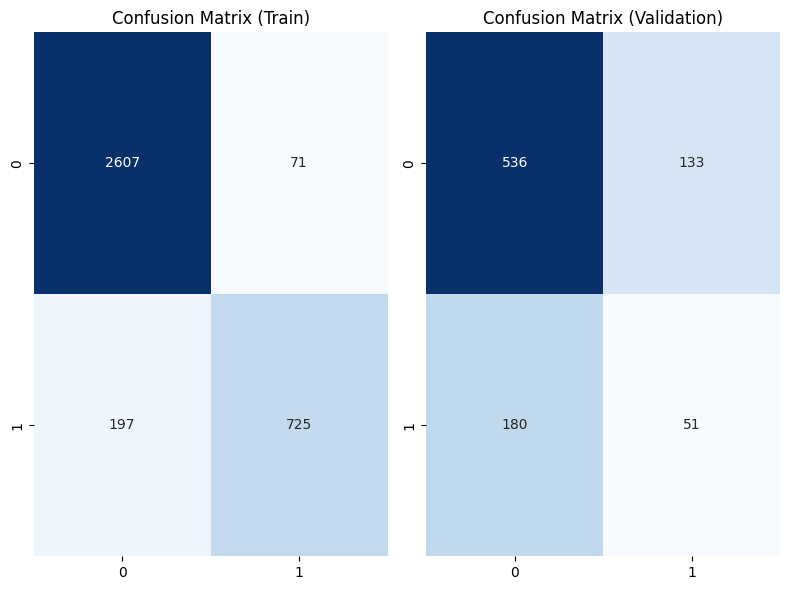

In [ ]:
eval_cm(model_xgb,X_train,y_train,X_val,y_val,drop_id_col_list)

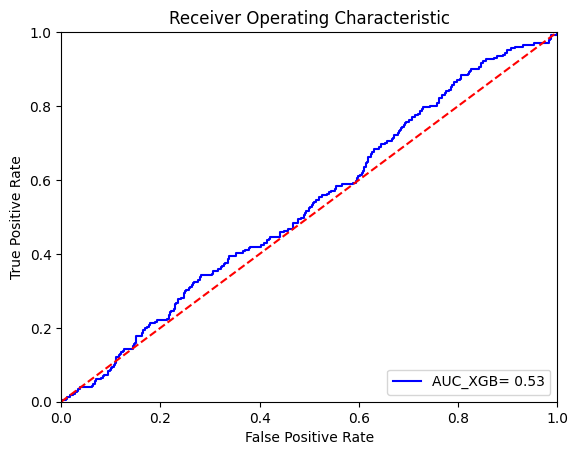

In [ ]:
# Compute ROC curve and ROC area
probs = model_xgb.predict_proba(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)


# Creating the ROC curve plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_XGB= %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Save the model

In [ ]:
import pickle
# Pickle the model
with open("output_folder/physician_conversion.pkl", "wb") as f:
    pickle.dump(model_xgb, f)


### Inference Data
- Saving Test Data as Inference set
- Training data for Model Monitoring

In [ ]:
inference_df = X_test.copy()
# inference_df['TARGET'] = y_test
inference_df.head()

,NPI_ID,HCP_ID,Age,Number_of_Rx,Rx_last_1_Month,Rx_last_3_Month,Rx_last_6_Month,Rx_last_12_Month,Claims_last_1_Month,Claims_last_3_Month,...,Promotional_medscape_last_3_month,Promotional_medscape_last_6_month,F2F_visit,F2F_visit_last_1_month,F2F_visit_last_3_month,VRC_visit_last_3_month,VRC_visit_last_6_month,VRC_visit_last_12_month,HCO_Affiliation_Type_Contract,HCO_Affiliation_Type_Referral
4637,4982891,HCP_4638,82,133,184,302,330,378,264,444,...,23,46,2,3,5,5,9,10,False,True
3387,2838371,HCP_3388,28,338,425,773,1544,2153,204,328,...,14,17,1,2,3,4,6,11,True,False
2730,4488773,HCP_2731,38,1100,1202,2180,3876,4878,264,486,...,20,23,2,3,4,5,7,8,False,False
593,8623941,HCP_594,84,866,1005,1280,1989,3550,56,102,...,17,33,2,4,5,4,6,9,True,False
2916,8596687,HCP_2917,62,908,1576,2036,2167,4210,103,179,...,26,46,2,4,7,4,8,10,False,True


In [ ]:
inference_df.to_csv('output_folder/Inference_data.csv')

In [ ]:
##Save Validation Data for Shap
df_validation = X_val.copy()
df_validation['TARGET'] = y_val
df_validation.to_csv('output_folder/Validation_data.csv')

In [ ]:
##Save Train Data for Shap
df_train = X_train.copy()
df_train['TARGET'] = y_train
df_validation.to_csv('output_folder/train_data.csv')